In [268]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import os
import soundfile
import librosa

Sample rate of the audio file:  8000


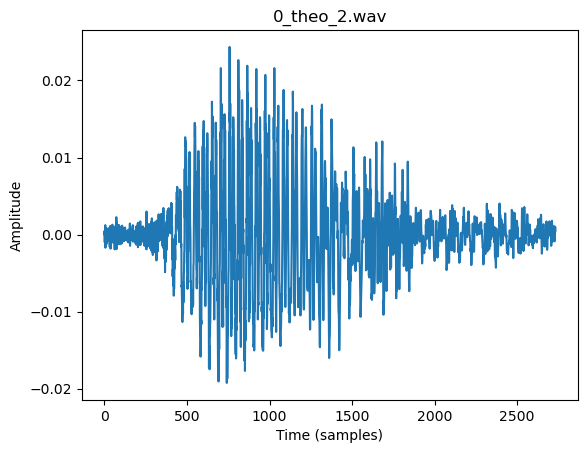

In [269]:
#folder_path = "data/audio/fold1"
folder_path = "data/audioMNIST/data"
# Get a list of all files in the folder_path
all_files = os.listdir(folder_path)

# Sample 3 files from the list
sample_file = np.random.choice(all_files, size=1, replace=False)

sr , _ = wavfile.read(folder_path + "/" + sample_file[0])
print("Sample rate of the audio file: ", sr)
y, sr = librosa.load(folder_path + "/" + sample_file[0], sr=sr)
plt.plot(y);
plt.title(sample_file[0]);
plt.xlabel('Time (samples)');
plt.ylabel('Amplitude');


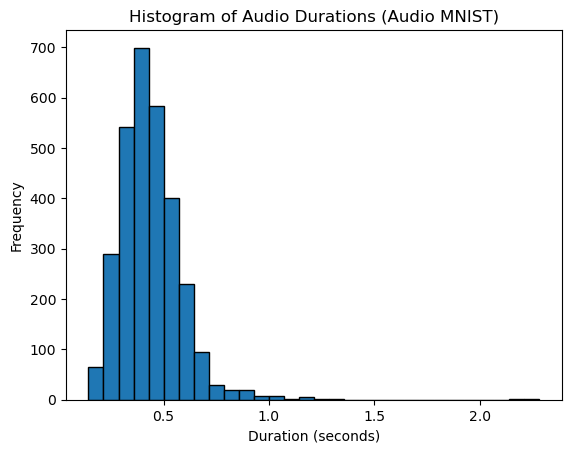

In [270]:
folder_path = "data/audioMNIST/data/"
        
durations = [len(librosa.load(folder_path+file, sr=sr)[0])/sr for file in all_files if file.endswith('.wav')]

plt.hist(durations, bins=30, edgecolor='black')
plt.title('Histogram of Audio Durations (Audio MNIST)')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.show()


In [271]:
max_duration = np.argmax(durations)
min_duration = np.argmin(durations)
print('Longest audio file:', all_files[max_duration], 'Duration:', durations[max_duration], 'seconds')
print('Shortest audio file:', all_files[min_duration], 'Duration:', durations[min_duration], 'seconds')

Longest audio file: 9_theo_16.wav Duration: 2.28275 seconds
Shortest audio file: 6_yweweler_3.wav Duration: 0.1435 seconds


In [272]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = np.percentile(durations, 1)
Q3 = np.percentile(durations, 99)
print('Q1:', Q1)
print('Q3:', Q3)

# Find the outliers
duration_outliers = [d for d in durations if d < Q1 or d > Q3]
np.size(duration_outliers)
print('Number of outliers:', np.size(duration_outliers))

Q1: 0.19262125
Q3: 0.9201599999999991
Number of outliers: 60


In [273]:
def pad_signal(S, max_length):
    dif_sample = abs(len(S) - max_length) # Calculate the differnce in desired signal length and the current signal length

    if len(S) % 2 != 0:
        padded_y = np.pad(S, (dif_sample//2, dif_sample//2 + 1), 'constant', constant_values=(0, 0))
    else:
        padded_y = np.pad(S, (dif_sample//2, dif_sample//2), 'constant', constant_values=(0, 0))

    return padded_y




In [274]:
padded_y = pad_signal(y, 8000)

In [275]:
len(padded_y)

8000

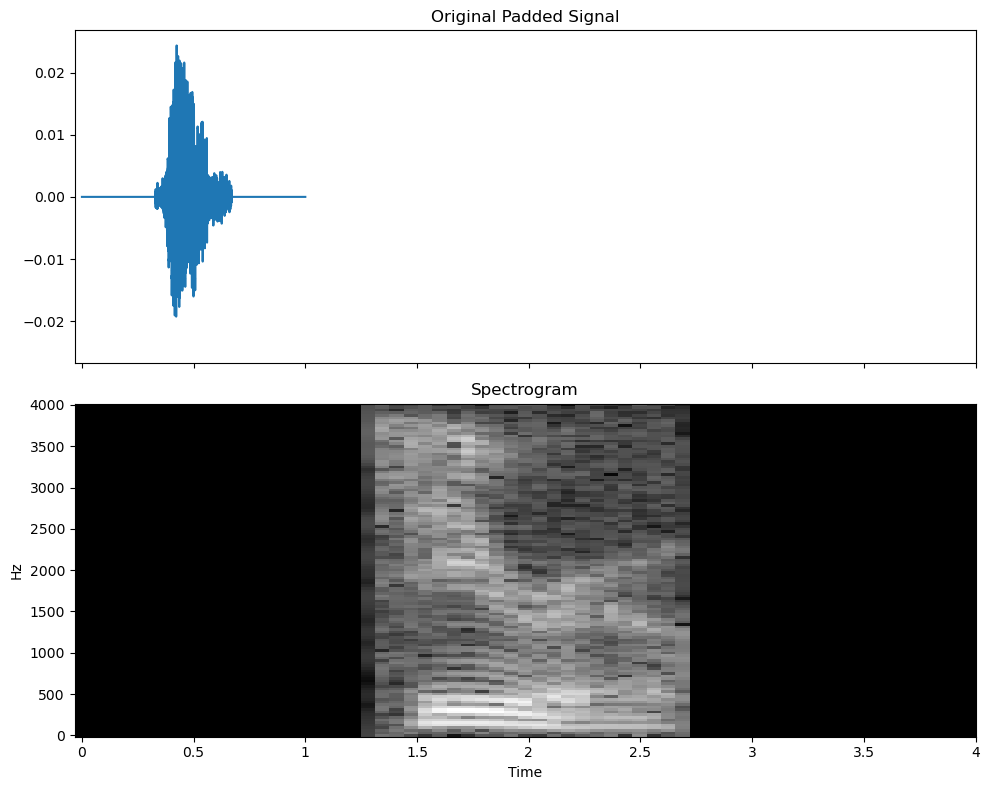

In [276]:
n_fft = 256
spec = np.abs(librosa.stft(padded_y, n_fft=n_fft, hop_length=n_fft//2))
epsilon = 1e-4
spec_db = np.array(20 * np.log10(spec + epsilon))
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(10, 8))

# Plot the original padded signal
librosa.display.waveshow(padded_y, sr=sr, ax=ax[0])
ax[0].set(title='Original Padded Signal', xlabel=None)
ax[0].label_outer()

# Plot the spectrogram
img = librosa.display.specshow(spec_db, sr=sr, x_axis='time', y_axis='linear', fmax=sr//2, fmin=0, cmap='grey')
ax[1].set(title='Spectrogram')

plt.tight_layout()
plt.show()

In [277]:
spec.shape

(129, 63)

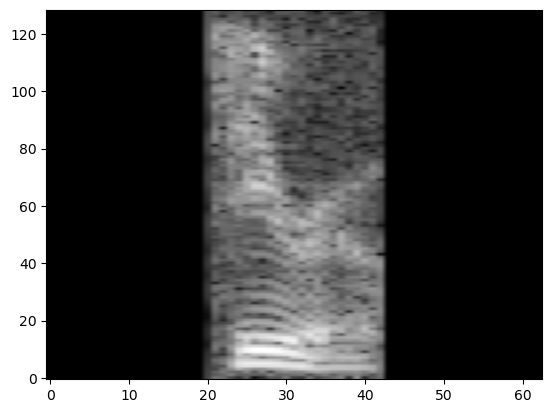

In [278]:
plt.imshow(spec_db, aspect='auto', origin='lower', cmap='gray')

In [279]:
file_name = sample_file[0].split('.')[0]
np.save(f'data/audioMNIST/data_spec/{file_name}.npy', spec_db)

#### Export all Spectrograms

In [280]:
def load_data(folder_path):
    # Get a list of all files in the folder_path
    all_files = os.listdir(folder_path)

    # Determine samplerate of signal
    sr , _ = wavfile.read(folder_path + "/" + all_files[0])

    audio_data = []
    # Load the audio files
    for file in all_files:
        if file.endswith('.wav'):
            y = librosa.load(folder_path + "/" + file, sr=sr)[0]
            audio_data.append((y,file))

    return audio_data

def trim_signals(data, max_db):
    trimmed_audio = []
    for y, file in data:
        if len(y) > 8000:
            continue # Skip audio files longer than 8000 samples
        y_trimmed, _ = librosa.effects.trim(y, top_db=max_db)
        trimmed_audio.append((y_trimmed, file))
    return trimmed_audio

def pad_segment(s, window_size):
    dif_sample = abs(len(s) - window_size) # Calculate the differnce in desired signal length and the current signal length
    if len(s) % 2 != 0:
        padded_y = np.pad(s, (dif_sample//2, dif_sample//2 + 1), 'constant', constant_values=(0, 0))
    else:
        padded_y = np.pad(s, (dif_sample//2, dif_sample//2), 'constant', constant_values=(0, 0))
    return padded_y

def stft(x, frame_size=256, overlap=128):
    num_segments = len(x) // overlap - 1 # Calculate the number of segments
    freq_bins = frame_size // 2 + 1 # Define the number of frequency bins
    spec = np.zeros((freq_bins, num_segments))
    t = 0
    for i in range(0, len(x)-frame_size, overlap):
        seg = x[i:i+frame_size]
        seg = np.hamming(len(seg)) * seg # Apply the hamming window
        if len(seg) < frame_size: # if the segment is shorter than the window size, we need to pad it (usually the last segment)
            seg = pad_segment(seg, frame_size)
        spec[:,t] = np.abs(np.fft.rfft(seg, n=frame_size)) #Compute the magnitude of frequency components
        t += 1
    return spec

def gen_spectgrams(audio_data, padding_length, n_fft=128):
    # Compute the mel spectrogram
    spects = []
    for audio in audio_data:
        if len(audio[0]) > 8000:
            continue # Skip audio files longer than 8000 samples
        y_trimmed, _ = librosa.effects.trim(audio[0], top_db=20)
        padded_y = pad_signal(y_trimmed, padding_length)
        spec = stft(padded_y, frame_size=n_fft, overlap=n_fft//2)
        epsilon = 1e-4
        spec_db = np.array(20 * np.log10(spec + epsilon))
        spects.append((spec_db, audio[1]))
    return spects

In [281]:
mnsit_data = load_data('data/audioMNIST/data')

audio_data = trim_signals(mnsit_data, max_db=20)
max_samples = np.max([len(y) for y, _ in audio_data])
print(f"Maximum number of samples: {max_samples}")

results = gen_spectgrams(mnsit_data, max_samples, n_fft = 256)

# Designated folder location to save the matrix files
output_folder = "data/audioMNIST/data_spec"
os.makedirs(output_folder, exist_ok=True)

# Iterate through the results and save each mel-spectrogram matrix as a .npy file
for mel_spect_db, file_name in results:
    output_path = os.path.join(output_folder, f"{os.path.splitext(file_name)[0]}.npy")
    np.save(output_path, mel_spect_db)

Maximum number of samples: 6457


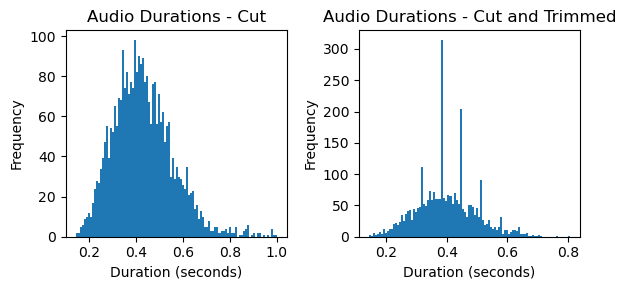

In [282]:
durations = [len(librosa.load(folder_path+file, sr=sr)[0]) for file in all_files if file.endswith('.wav')]
durations_cut = [x/sr for x in durations if x < 8000]
durations_trimmed = [len(audio)/sr for audio, _ in audio_data]


fig, axs = plt.subplots(1, 2, figsize=(6, 3))

# Plot the first histogram
axs[0].hist(durations_cut, bins=100)
axs[0].set_title('Audio Durations - Cut')
axs[0].set_xlabel('Duration (seconds)')
axs[0].set_ylabel('Frequency')

# Plot the second histogram
axs[1].hist(durations_trimmed, bins=100)
axs[1].set_title('Audio Durations - Cut and Trimmed')
axs[1].set_xlabel('Duration (seconds)')
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

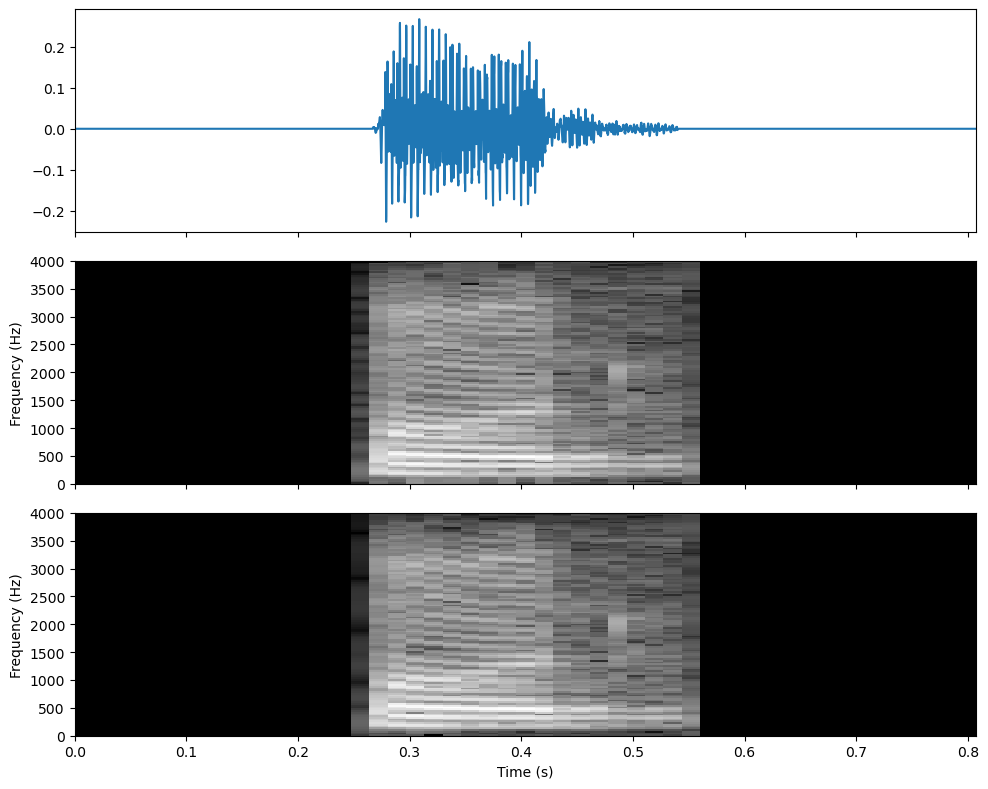

In [283]:
y = audio_data[1227][0]
padded_y = pad_signal(y, 6457)
spec = stft(padded_y, frame_size=256, overlap=128)
epsilon = 1e-4
spec_db = np.array(20 * np.log10(spec + epsilon))
lib = np.abs(librosa.stft(padded_y, n_fft=256, hop_length=n_fft//2, center=False))
lib_db = np.array(20 * np.log10(lib + epsilon))


# Plot the original padded signal with consistent x-axis range
# Time axis for the original signal
time = np.linspace(0, len(padded_y)/sr, len(padded_y))

# Time axis for the spectrograms
n_frames_spec = spec_db.shape[1]  # Number of time frames in your custom spectrogram
n_frames_lib = lib_db.shape[1]  # Number of time frames in the librosa spectrogram

time_spec = np.linspace(0, len(padded_y)/sr, n_frames_spec)
time_lib = np.linspace(0, len(padded_y)/sr, n_frames_lib)

# Plotting
fig, ax = plt.subplots(3, 1, figsize=(10, 8))

# Plot the original padded signal
ax[0].plot(time, padded_y)
ax[0].set_xlim([0, len(padded_y)/sr])
ax[0].label_outer()

# Plot your custom spectrogram with proper time axis
img1 = ax[1].imshow(spec_db, aspect='auto', origin='lower', extent=[0, len(padded_y)/sr, 0, sr//2], cmap='gray', interpolation='none')
ax[1].set_xlim([0, len(padded_y)/sr])
ax[1].set_ylabel("Frequency (Hz)")
ax[1].label_outer()

# Plot the `librosa` spectrogram with proper time axis
img2 = ax[2].imshow(lib_db, aspect='auto', origin='lower', extent=[0, len(padded_y)/sr, 0, sr//2], cmap='gray', interpolation='none')
ax[2].set_xlim([0, len(padded_y)/sr])
ax[2].set_xlabel("Time (s)")
ax[2].set_ylabel("Frequency (Hz)")

# Adjust layout
plt.tight_layout()
plt.show()

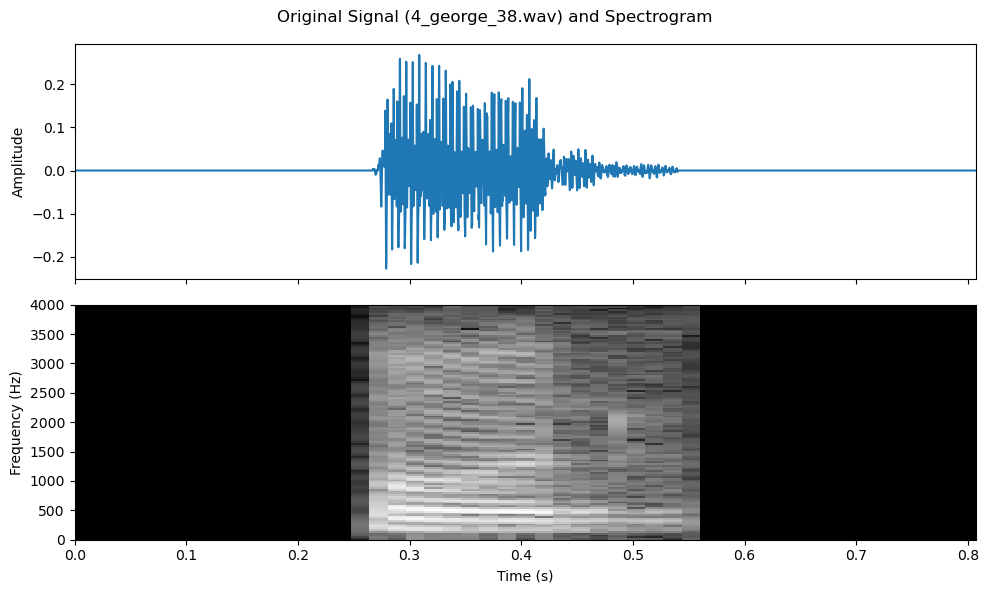

In [284]:
y = audio_data[1227][0]
padded_y = pad_signal(y, 6457)
spec = stft(padded_y, frame_size=256, overlap=128)
epsilon = 1e-4
spec_db = np.array(20 * np.log10(spec + epsilon))

# Plot the original padded signal with consistent x-axis range
# Time axis for the original signal
time = np.linspace(0, len(padded_y)/sr, len(padded_y))

# Time axis for the spectrograms
n_frames_spec = spec_db.shape[1]  # Number of time frames in your custom spectrogram
n_frames_lib = lib_db.shape[1]  # Number of time frames in the librosa spectrogram

time_spec = np.linspace(0, len(padded_y)/sr, n_frames_spec)
time_lib = np.linspace(0, len(padded_y)/sr, n_frames_lib)

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
fig.suptitle(f'Original Signal ({audio_data[1227][1]}) and Spectrogram', fontsize=12)

# Plot the original padded signal
ax[0].plot(time, padded_y)
ax[0].set_xlim([0, len(padded_y)/sr])
ax[0].set_ylabel("Amplitude")
ax[0].label_outer()

# Plot your custom spectrogram with proper time axis
img1 = ax[1].imshow(spec_db, aspect='auto', origin='lower', extent=[0, len(padded_y)/sr, 0, sr//2], cmap='gray', interpolation='none')
ax[1].set_xlim([0, len(padded_y)/sr])
ax[1].set_ylabel("Frequency (Hz)")
ax[1].label_outer()
ax[1].set_xlabel("Time (s)")


# Adjust layout
plt.tight_layout()
plt.show()

In [285]:
lib_db.shape

(129, 49)

In [290]:
spec_db.shape

(129, 49)

In [287]:
file_name = '0_george_5'

spec_db = np.load(f'data/audioMNIST/data_spec/{file_name}.npy')

amplitude_spec = np.array(10**(spec_db/20))

y_reconstructed = librosa.griffinlim(amplitude_spec, n_iter=64, hop_length=n_fft//2, n_fft=n_fft)




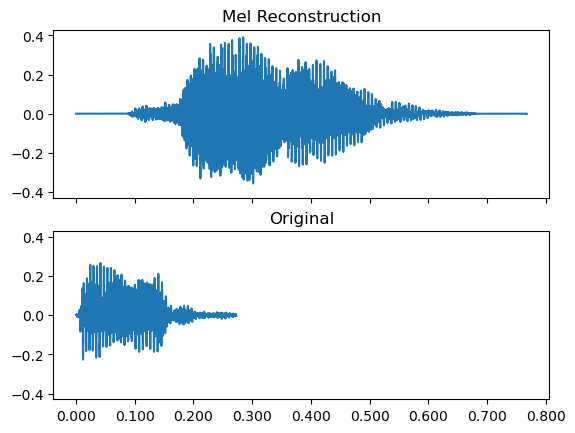

In [288]:
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)

librosa.display.waveshow(y_reconstructed, sr=sr, ax=ax[0])
librosa.display.waveshow(y, sr=sr, ax=ax[1])
ax[0].set(title='Mel Reconstruction', xlabel=None)
ax[0].label_outer()
ax[1].set(title='Original', xlabel=None)
ax[1].label_outer()

In [289]:
import soundfile as sf

sf.write('output.wav', y_reconstructed, sr)